In [1]:
# Interface detector based on max_gradient_classifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def mov_avg(array, window_length, *, method='same'):
    array_avg = np.convolve(array, np.ones(window_length), method) / window_length
    return array_avg

## Synthetic Data
I used this for development and testing. You will find an example with a proper profile later in the document.

I didn't comment much on this section becuase it is just a prototype.

In [3]:
result_grid = np.ones([250, 1000])
result_grid[0:51, :] = 0
result_grid[51:101, :] = 1
result_grid[101:151, :] = 2
result_grid[151:201, :] = 3
result_grid[201:250, :] = 4
depths = np.linspace(0, 200, 250)
result_grid_rolled = np.roll(result_grid, -1, axis=0)
result = result_grid - result_grid_rolled
result[-1, :] = 0

In [4]:
interface_id = []
interface_n = []
# This would be enough in a perfect profile
for column in result.T:
    indexes = np.where(column != 0)
    interface_n.append(len(indexes[0]))
    interface_id.append(indexes)
interface_id[0] =  [np.array([50, 100, 150])]
interface_id[5] = [np.array([100, 150])]
interface_id[-1] = [np.array([50, 200])]
interface_number = np.bincount(interface_n).argmax()  # Correct number of layers, from kind of voting
#print(result.shape[1])
interface_depths_ids = np.ones([interface_number, result.shape[1]])*float("NaN")
interface_depths = np.ones([interface_number, result.shape[1]])*float("NaN")
incomplete_detections = []
# This loop checks if each column has a correct number of layers
for col_num in range(len(interface_id)):
    if len(interface_id[col_num][0]) == interface_number:
        interface_depths_ids[:, col_num] = interface_id[col_num][0]
        interface_depths[:, col_num] = depths[interface_id[col_num][0]]
    else:
        # If not, mark layer to be investigated again
        incomplete_detections.append(col_num)

In [5]:
'''
This part of the code solves the problem of columns in which there are less layers found than there should be.
Currently possibility of detected too many layers is not considered. TODO
The detected interfaces should be matched to their neighbours based on the principle of the smallest difference.
this is what variables diff and pos achieve.
This is done separately for each column, marked in previous step to be investigate again.

The if structure in the for loop handles two corner cases. Since I am calling neighbouring columns in the
line where variable diff is defined, I had to consider, what to do if first and last columns will be investigated again.
If and elif handle it and else handles all the columns between them.
I know it would be enough to wrap only the diff line in this structure, but when I was developing the code
I though, it may be necessary to make some more changes and it kind of stayed this way.
'''
for col_num_inc in incomplete_detections:
    if col_num_inc is 0:  # Special case fo the first column
        new_ids = np.ones([interface_number, 1])*float("NaN")
        for depth_id in interface_id[col_num_inc][0]:
            depth_id_array = np.ones([interface_number, 1])*depth_id
            # Calculate the difference between all detected interfaces and the neighbours (in terms of depth)
            diff = interface_depths[:, col_num_inc+1].reshape([interface_number, 1]) - depth_id_array
            # Find which interface is the closest match (in term of depth)
            pos = np.where(abs(diff).reshape([len(diff)]) == np.amin(abs(diff)))
            new_ids[int(pos[0])] = depths[depth_id]
        interface_depths[:,col_num_inc] = new_ids.reshape([interface_number])
    elif col_num_inc == result.shape[1]-1:  # Special case for the last column
        new_ids = np.ones([interface_number, 1])*float("NaN")
        for depth_id in interface_id[col_num_inc][0]:
            depth_id_array = np.ones([interface_number, 1])*depth_id
            # Calculate the difference between all detected interfaces and the neighbours (in terms of depth)
            diff = interface_depths[:, col_num_inc-1].reshape([interface_number, 1]) - depth_id_array
             # Find which interface is the closest match (in term of depth)
            pos = np.where(abs(diff).reshape([len(diff)]) == np.amin(abs(diff)))
            new_ids[int(pos[0])] = depths[depth_id]
        interface_depths[:,col_num_inc] = new_ids.reshape([interface_number])
    else:  # Not special case for every other column
        new_ids = np.ones([interface_number, 1])*float("NaN")
        for depth_id in interface_id[col_num_inc][0]:
            depth_id_array = np.ones([interface_number, 1])*depth_id
             # Calculate the difference between all detected interfaces and the neighbours (in terms of depth)
            diff = ((interface_depths[:, col_num_inc-1].reshape([interface_number, 1])+interface_depths[:, col_num_inc-1].reshape([interface_number, 1]))/2) - depth_id_array
            #print(diff.reshape([len(diff)]))
            #print(np.amin(abs(diff)))
             # Find which interface is the closest match (in term of depth)
            pos = np.where(abs(diff).reshape([len(diff)]) == np.amin(abs(diff)))
            new_ids[int(pos[0])] = depths[depth_id]
        interface_depths[:,col_num_inc] = new_ids.reshape([interface_number])


## Inverted profile
#### Load data
y_pred_grid_deri was obtained as follows:
y_pred_grid_rolled = np.roll(y_pred_grid, -1, axis=0)
y_pred_grid_deri = y_pred_grid - y_pred_grid_rolled
#### Assumptions
1. The classes only increase down the column.
2. As a result of 1, np.where(column != 0), will return indexes increasing order.

In [6]:
# X - values used in the grid
xi = pd.read_csv('interface_detector_demo/xi_demo.csv', skiprows=1).drop(columns='0').to_numpy()
# Y - depth, vaulues used in the grid
yi = pd.read_csv('interface_detector_demo/yi_demo.csv', skiprows=1).drop(columns='0').to_numpy()
# Grid with data defined with xi and yi
y_pred_grid_deri = pd.read_csv('interface_detector_demo/profile_grided_derivative.csv', skiprows=1).drop(columns='0').to_numpy()
# Since y_pred_grid_deri is obtained with roll, last row will always be non-zero, hence non existing interface at the
# bottom of the profile will be added. Following line fixes it.
y_pred_grid_deri[-1, :] = 0

You won't see anything in the next figure. y_pred_grid_deri is a result of subtracting rolled profile from itself. Therefore only non zero values are the ones that are related to change of class in the colum.

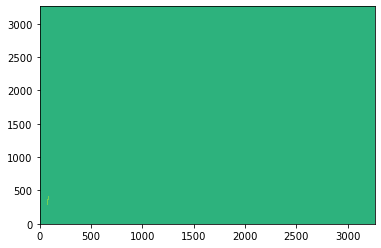

In [7]:
plt.contourf(y_pred_grid_deri)

In [8]:
min_thickness = 1  # Minimal thickness of layer in m
interface_id = []
interface_n = []
interface_depth = []
# The algorithm iterates over each column individually
for column in y_pred_grid_deri.T:
    # Any change of classes in a column will result in a non-zero value, (see Load data md cell)
    indexes = list(np.where(column != 0))  # List of potential positions of interface
    if indexes[0].size == 1:  # Only one interface detected
        # This is the simple case, no need to check the thickness of the layer.
        interface_n.append(len(indexes[0]))
        interface_id.append(indexes)
        interface_depth.append(yi[indexes])
    else:  # Multiple potential interfaces detected
        indexes_temp = []
        depths_temp = []
        indexes_copy = indexes
        all_too_thin_layers_removed = False  # Set to false, in order to make sure while loop runs at least once
        '''
        The idea is, that if there is more than 1 class changes detected, loop will iterate over them,
        check the distance between a currently considered index and tha one that comes next, until non of them
        violate condition that thickness layer is less than defined minimum thickness.
        '''
        while all_too_thin_layers_removed is False:
            all_too_thin_layers_removed = True
            # Line above: If none pair of indexes will result in a layer, that is not thick enough
            # to be considered as valid layer, it is the end of looking for invalid layers.
            # No need to iterate anymore. It will stay true, throughout the last iteration and loop
            # will end.
            '''
            I am not entirely sure, why it works like this but next if solves following problem:
            if a list with more than one index is considered and due to insufficient thickness
            it reduces to a single index, it will be returned as integer instead of list,
            then at next iteration integer will crash the code, due to indexing.
            There is probably nicer way around it, but for now it works.
            So if indexes_copy is reduced to the integer, there is no need to iterate over it again,
            as it contains only one index, so there is no thickness to consider anymore.
            '''
            if isinstance(indexes_copy[0], int) is False:
                for index_id in range(indexes_copy[0].size-1):
                    # upper line: -1 in range so that indexes can be considered in pairs like: a and a+1: 0 and 1, 1 and 2 and so on.
                    # lower line: a currently considered pair of indexes is used to obtain depths of the potential interfaces
                    diff = yi[indexes[0][index_id+1]] - yi[indexes[0][index_id]]  # calculate the potential layer thickness
                    if abs(diff) <= min_thickness:  # Check if the layer is thick enough to be considered an independent layer.
                        indexes_temp.append(int(round((indexes[0][index_id+1]+indexes[0][index_id])/2)))
                        # Every violation of thickness condition will set it to false and force one more loop run over the list of indexes to check if all indexes comply with this condition.
                        all_too_thin_layers_removed = False
                    else:
                        indexes_temp.append(indexes[0][index_id])
                if abs(yi[indexes[0][-1]] - yi[indexes[0][-2]]) >= min_thickness:
                    # Just an extra check to verify, that last and pre last indexes don't violate thickness condition.
                    indexes_temp.append(indexes[0][-1])
                indexes_copy = indexes_temp # Modified list has to be used for next iteration
                indexes_temp = []
        # This part runs, when there are none pairs of indexes left, that violate thickness condition
        # Store results and proceed to the next column.
        interface_n.append(len(indexes_copy))
        interface_id.append(indexes_copy)
        interface_depth.append(yi[indexes_copy])
interface_number = np.bincount(interface_n).argmax()

/home/felikskrno/anaconda3/envs/SlopeStability/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


This test profile contains only one interface. Results should only contain one interface, but everywhere where interface_n has value greater than 1 and where interface_id and interface_depth contain arrays with multiple values, the distance between two potential interfaces exceeded threshold defined in min_thickness

In [9]:
print(interface_number)
print(interface_n)
print(interface_id)
#print(interface_depth)

2
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 3, 3, 4, 4, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

In [42]:
interface_number = np.max(interface_n)
interface_depths_ids = np.ones([interface_number, y_pred_grid_deri.shape[1]])*float("NaN")
interface_depths = np.ones([interface_number, y_pred_grid_deri.shape[1]])*float("NaN")
depths = yi
print(len(interface_n))
incomplete_detections = []
for column_id in range(len(interface_n)):
    incomplete_detections.append(column_id)

3262


In [43]:
interface_depths_ids = np.ones([interface_number, y_pred_grid_deri.shape[1]])*float("NaN")
interface_depths = np.ones([interface_number, y_pred_grid_deri.shape[1]])*float("NaN")
incomplete_detections = []
# This loop checks if each column has a correct number of layers
for col_num in range(len(interface_id)):
    if len(interface_id[col_num]) == interface_number:
        interface_depths_ids[:, col_num] = np.array(interface_id[col_num]).reshape([1, len(interface_id[col_num])])
        interface_depths[:, col_num] = np.array(depths[interface_id[col_num][0]]).reshape([1, len(depths[interface_id[col_num][0]])])
    else:
        # If not, mark layer to be investigated again
        incomplete_detections.append(col_num)

In [12]:
print(np.nanmean(interface_depths_ids, axis=1))
print(interface_id[0][0])
print(depths[depth_id])

[312.33333333 365.83333333 419.16666667 530.        ]
516
[-2.47930083]


In [44]:
# Assign depths and ids to interfaces based on their relation to the mean of each interface (including only

for col_num_inc in incomplete_detections:
    new_depths = np.ones([interface_number, 1])*float("NaN")
    new_ids = np.ones([interface_number, 1])*float("NaN")
    for depth_id in interface_id[col_num_inc]:
        depth_id_array = np.ones([interface_number, 1])*depths[depth_id]
        # Calculate the difference between all detected interfaces and the neighbours (in terms of depth)
        mean = np.nanmean(interface_depths, axis=1).reshape([interface_number, 1])
        diff = mean - depth_id_array
        # Find which interface is the closest match (in term of depth)
        pos = np.where(abs(diff).reshape([len(diff)]) == np.nanmin(abs(diff)))
        if pos[0].size != 1:
            pos = np.unique(np.array(pos[0]))
        new_depths[int(pos[0])] = depths[depth_id]
        new_depths = new_depths.reshape([interface_number])
        new_ids[int(pos[0])] = depth_id
        new_ids = new_ids.reshape([interface_number])

        if (new_depths != interface_depths[:,col_num_inc].reshape([interface_number])).any:
            reiterate = True
    temp = interface_depths[:,col_num_inc]
    interface_depths[:,col_num_inc] = new_depths.reshape([interface_number,])
    interface_depths_ids[:, col_num_inc] = new_ids.reshape([interface_number,])

In [47]:
for col_num_inc in incomplete_detections:
    if col_num_inc is 0:  # Special case fo the first column
        new_ids = np.ones([interface_number, 1])*float("NaN")
        for depth_id in interface_id[col_num_inc]:
            depth_id_array = np.ones([interface_number, 1])*depths[depth_id]
            # Calculate the difference between all detected interfaces and the neighbours (in terms of depth)
            mean = np.nanmean(interface_depths, axis=1).reshape([interface_number, 1])
            diff = mean - depth_id_array
            # Find which interface is the closest match (in term of depth)
            pos = np.where(abs(diff).reshape([len(diff)]) == np.nanmin(abs(diff)))
            new_ids[int(pos[0])] = depths[depth_id]
        interface_depths[:,col_num_inc] = new_ids.reshape([interface_number])
    elif col_num_inc == result.shape[1]-1:  # Special case for the last column
        new_ids = np.ones([interface_number, 1])*float("NaN")
        for depth_id in interface_id[col_num_inc][0]:
            depth_id_array = np.ones([interface_number, 1])*depth_id
            # Calculate the difference between all detected interfaces and the neighbours (in terms of depth)
            diff = interface_depths[:, col_num_inc-1].reshape([interface_number, 1]) - depth_id_array
             # Find which interface is the closest match (in term of depth)
            pos = np.where(abs(diff).reshape([len(diff)]) == np.nanmin(abs(diff)))
            new_ids[int(pos[0])] = depths[depth_id]
        interface_depths[:,col_num_inc] = new_ids.reshape([interface_number])
    else:  # Not special case for every other column
        new_ids = np.ones([interface_number, 1])*float("NaN")
        for depth_id in interface_id[col_num_inc]:
            depth_id_array = np.ones([interface_number, 1])*depth_id
             # Calculate the difference between all detected interfaces and the neighbours (in terms of depth)
            diff = ((interface_depths[:, col_num_inc-1].reshape([interface_number, 1])+interface_depths[:, col_num_inc-1].reshape([interface_number, 1]))/2) - depth_id_array
            #print(diff.reshape([len(diff)]))
            #print(np.amin(abs(diff)))
             # Find which interface is the closest match (in term of depth)
            #print(abs(diff).reshape([len(diff)]))
            #print(np.nanmin(abs(diff)))
            if pos[0].size != 1:
                pos = np.unique(np.array(pos[0]))
            pos = np.where(abs(diff).reshape([len(diff)]) == np.nanmin(abs(diff)))
            new_ids[int(pos[0])] = depths[depth_id]
        interface_depths[:,col_num_inc] = new_ids.reshape([interface_number])

TypeError: only size-1 arrays can be converted to Python scalars

In [41]:
interface_continous = []
for int_id in range(interface_depths.shape[0]):
    interface_curr = interface_depths[int_id, :]
    conti = interface_curr.size - np.count_nonzero(np.isnan(interface_curr))
    print(conti/interface_curr.size)
    if conti/interface_curr.size > 0.5:
        #print(int_id)
        interface_continous.append(int_id)
    else:
        print('Interface is not continous enogh')

0.2676272225628449
Interface is not continous enogh
0.48252605763335377
Interface is not continous enogh
0.3077866339668915
Interface is not continous enogh
0.47670141017780504
Interface is not continous enogh


In [15]:
interface_ids_final = np.zeros([len(interface_continous), depths.size+1])
interface_depths_final = np.zeros([len(interface_continous), depths.size+1])
for inter_id in range(len(interface_continous)):
    # Depth part
    interface_depths_curr = interface_depths[inter_id, :]
    nan_ids = np.argwhere(np.isnan(interface_depths_curr))
    print(nan_ids.size)
    interface_depths_curr_mean = np.nanmean(interface_depths_curr)
    interface_depths_curr[nan_ids] = interface_depths_curr_mean
    print(interface_depths_curr.size)
    interface_curr = interface_depths_curr.reshape([1, interface_depths_curr.size])
    interface_depths_final[inter_id, :] = interface_depths_curr
    # Ids part
    interface_ids_curr = interface_depths_ids[inter_id, :]
    nan_ids = np.argwhere(np.isnan(interface_ids_curr))
    print(nan_ids.size)
    interface_ids_curr_mean = np.nanmean(interface_ids_curr)
    interface_ids_curr[nan_ids] = interface_ids_curr_mean
    print(interface_ids_curr.size)
    interface_curr = interface_ids_curr.reshape([1, interface_ids_curr.size])
    interface_ids_final[inter_id, :] = interface_ids_curr
    #interface_depths_final = np.concatenate((interface_depths_final, interface_curr), axis=0)

1819
3262
1819
3262


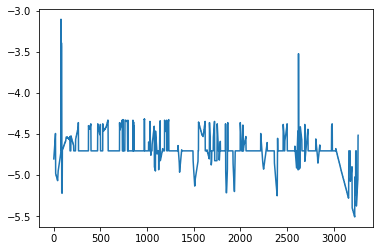

In [16]:
#plt.scatter(xi, yi, c=y_pred_grid_deri)
plt.plot(interface_depths_final.reshape([interface_depths_final.size]))

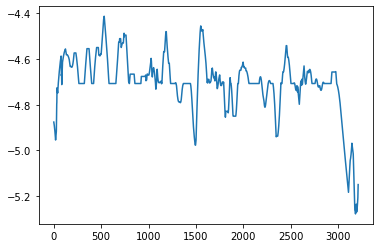

In [17]:
inter_final_movavg = mov_avg(interface_depths_final.reshape([interface_depths_final.size]), 50, method='valid')
plt.plot(inter_final_movavg.reshape([inter_final_movavg.size]))

In [18]:
no_misplacements_detected = False
while no_misplacements_detected is False:
    for col_num_inc in incomplete_detections:
        if col_num_inc is 0:  # Special case fo the first column
            print(col_num_inc)
            print(interface_id[col_num_inc][0])
            new_ids = np.ones([interface_number, 1])*float("NaN")
            for depth_id in interface_id[col_num_inc]:
                depth_id_array = np.ones([interface_number, 1])*depth_id
                # Calculate the difference between all detected interfaces and the neighbours (in terms of depth)
                mean = np.nanmean(interface_depths_ids, axis=1).reshape([interface_number, 1])
                diff = mean - depth_id_array
                # Find which interface is the closest match (in term of depth)
                pos = np.where(abs(diff).reshape([len(diff)]) == np.nanmin(abs(diff)))
                new_ids[int(pos[0])] = depths[depth_id]
            interface_depths[:,col_num_inc] = new_ids.reshape([interface_number])
        elif col_num_inc == result.shape[1]-1:  # Special case for the last column
            new_ids = np.ones([interface_number, 1])*float("NaN")
            for depth_id in interface_id[col_num_inc][0]:
                depth_id_array = np.ones([interface_number, 1])*depth_id
                # Calculate the difference between all detected interfaces and the neighbours (in terms of depth)
                diff = interface_depths[:, col_num_inc-1].reshape([interface_number, 1]) - depth_id_array
                 # Find which interface is the closest match (in term of depth)
                pos = np.where(abs(diff).reshape([len(diff)]) == np.nanmin(abs(diff)))
                new_ids[int(pos[0])] = depths[depth_id]
            interface_depths[:,col_num_inc] = new_ids.reshape([interface_number])
        else:  # Not special case for every other column
            new_ids = np.ones([interface_number, 1])*float("NaN")
            for depth_id in interface_id[col_num_inc]:
                depth_id_array = np.ones([interface_number, 1])*depth_id
                 # Calculate the difference between all detected interfaces and the neighbours (in terms of depth)
                diff = ((interface_depths[:, col_num_inc-1].reshape([interface_number, 1])+interface_depths[:, col_num_inc-1].reshape([interface_number, 1]))/2) - depth_id_array
                #print(diff.reshape([len(diff)]))
                #print(np.amin(abs(diff)))
                 # Find which interface is the closest match (in term of depth)
                print(abs(diff).reshape([len(diff)]))
                print(np.nanmin(abs(diff)))
                if pos[0].size != 1:
                    pos = np.unique(np.array(pos[0]))
                pos = np.where(abs(diff).reshape([len(diff)]) == np.nanmin(abs(diff)))
                new_ids[int(pos[0])] = depths[depth_id]
            interface_depths[:,col_num_inc] = new_ids.reshape([interface_number])


## New idea - best fit lines for each class

In [72]:
# X - values used in the grid
xi = pd.read_csv('interface_detector_demo/xi_demo.csv', skiprows=1).drop(columns='0').to_numpy()
# Y - depth, vaulues used in the grid
yi = pd.read_csv('interface_detector_demo/yi_demo.csv', skiprows=1).drop(columns='0').to_numpy()
depths = yi
# Grid with data defined with xi and yi
y_pred_grid_deri = pd.read_csv('interface_detector_demo/profile_grided_derivative.csv', skiprows=1).drop(columns='0').to_numpy()
# Since y_pred_grid_deri is obtained with roll, last row will always be non-zero, hence non existing interface at the
# bottom of the profile will be added. Following line fixes it.
y_pred_grid_deri[-1, :] = 0
y_pred_grid = pd.read_csv('interface_detector_demo/y_pred_grid.csv', skiprows=1).drop(columns='0').to_numpy()
y_pred_col_num = y_pred_grid.shape[1]

In [73]:
y_pred_grid_copy = y_pred_grid.copy()
y_pred_uniq = np.unique(y_pred_grid)
print(y_pred_uniq)
#y_pred_new_values = y_pred_uniq + np.arange(0, len(y_pred_uniq), 1)*2
y_pred_new_values = np.zeros(len(y_pred_uniq))
for number in np.arange(1,len(y_pred_uniq),1):
    print(number)
    y_pred_new_values[number] = y_pred_new_values[number - 1] + number
print(y_pred_new_values)
for id_num in range(len(y_pred_uniq)):
    y_pred_grid_copy[y_pred_grid_copy == y_pred_uniq[id_num]] = y_pred_new_values[id_num]
#y_pred_grid_copy[y_pred_grid_copy == 0] = float('NaN')
print(np.unique(y_pred_grid_copy))

[0. 1. 2. 3. 4.]
1
2
3
4
[ 0.  1.  3.  6. 10.]
[ 0.  1.  6. 10.]


In [74]:
result_grid_rolled = np.roll(y_pred_grid_copy, -1, axis=0)
y_pred_grid_deri = y_pred_grid_copy - result_grid_rolled
y_pred_grid_deri[-1, :] = 0
print(np.unique(y_pred_grid_deri))
potential_interfaces_values = []
for value in np.unique(y_pred_grid_deri):
    print(str(value)+': '+str((np.count_nonzero(y_pred_grid_deri == value)/y_pred_col_num)*100))
    if (np.count_nonzero(y_pred_grid_deri == value)/y_pred_col_num)*100 > 50:
        if value != 0:
            potential_interfaces_values.append(value)

[-10.  -9.  -6.  -5.  -4.  -1.   0.   1.]
-10.0: 1.2568976088289392
-9.0: 11.95585530349479
-6.0: 74.67811158798283
-5.0: 12.109135499693439
-4.0: 86.78724708767626
-1.0: 24.310239117106068
0.0: 325888.6572654813
1.0: 0.2452483139178418


In [15]:
temp = np.where(y_pred_grid_deri == -6)
print(np.where(y_pred_grid_deri == -6))

(array([266, 268, 270, ..., 492, 497, 502]), array([2481, 2482, 2483, ...,    2,    1,    0]))


In [75]:
interface_ids = np.zeros([len(potential_interfaces_values), y_pred_col_num])*float("NaN")
interface_depths = np.zeros([len(potential_interfaces_values), y_pred_col_num])*float("NaN")
for inter_id in range(len(potential_interfaces_values)):
    for col_id in range(y_pred_col_num):
        ids_temp = np.where(y_pred_grid_deri[:, col_id] == potential_interfaces_values[inter_id])
        if ids_temp[0].size > 1:
            print('a')
            ids_temp = int(np.mean(ids_temp))
        elif ids_temp[0].size == 0:
            continue
        print(ids_temp[0].size)
        print(ids_temp[0][0])
        interface_ids[inter_id, col_id] = ids_temp[0][0]
        interface_depths[inter_id, col_id] = depths[ids_temp[0][0]]

1
502
1
497
1
492
1
486
1
481
1
476
1
471
1
466
1
461
1
456
1
450
1
445
1
440
1
435
1
430
1
425
1
419
1
414
1
409
1
404
1
399
1
396
1
394
1
394
1
394
1
393
1
391
1
389
1
387
1
385
1
383
1
382
1
383
1
384
1
385
1
386
1
388
1
389
1
390
1
391
1
392
1
393
1
394
1
395
1
396
1
397
1
398
1
399
1
400
1
401
1
402
1
404
1
405
1
406
1
407
1
408
1
409
1
410
1
411
1
412
1
413
1
414
1
415
1
416
1
417
1
419
1
420
1
421
1
422
1
423
1
424
1
425
1
426
1
427
1
428
1
429
1
430
1
431
1
432
1
433
1
435
1
434
1
432
1
430
1
428
1
336
1
335
1
358
1
359
1
358
1
357
1
356
1
355
1
354
1
352
1
351
1
350
1
349
1
348
1
347
1
345
1
344
1
343
1
342
1
341
1
340
1
338
1
337
1
336
1
335
1
334
1
333
1
332
1
330
1
329
1
328
1
327
1
326
1
325
1
323
1
322
1
321
1
320
1
319
1
318
1
316
1
315
1
314
1
313
1
312
1
311
1
309
1
308
1
307
1
306
1
305
1
306
1
308
1
310
1
311
1
313
1
315
1
316
1
318
1
320
1
321
1
323
1
324
1
326
1
328
1
329
1
331
1
333
1
334
1
336
1
338
1
339
1
341
1
342
1
344
1
346
1
347
1
349
1
351
1
352
1
354
1
35

In [30]:
print(np.nanmean(interface_depths[0,:]))
print(np.nanmean(interface_depths[1,:]))

-3.6582555745389236
-4.635393008864598


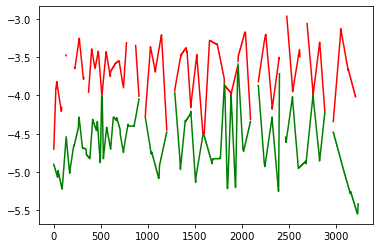

In [67]:
plt.plot(interface_depths[0,:], 'r')
plt.plot(interface_depths[1,:], 'g')

In [33]:
line = np.polynomial.polynomial.Polynomial.fit(xi.reshape([3261]),interface_depths[0,0:3261].reshape([3261]),1)
line.convert().coef

array([nan, nan])

In [40]:
import statsmodels.api as smapi
regression = smapi.OLS(xi.reshape([3261]),interface_depths[0,0:3261].reshape([3261]), missing='drop')
result = regression.fit()
print(result.params)

[-0.0950136]


In [44]:
mean_val = np.nanmean(interface_depths[0,0:3261])
interface_depths_copy = interface_depths[0,0:3261].copy()
interface_depths_copy[np.isnan(interface_depths_copy)] = mean_val
par = np.polyfit(xi.reshape([3261]), interface_depths_copy.reshape([3261]), 1, full=True)
print(par[0][1])

-3.6582621657774346


In [68]:
temp = interface_depths[0,0:3261].copy()
x = xi[~np.isnan(temp)].reshape([xi[~np.isnan(temp)].size])
y = temp[~np.isnan(temp)].reshape([xi[~np.isnan(temp)].size])
par_2 = np.polyfit(x, y, 1, full=True)
print(par_2[0][1])

-3.658660602569427


Apparently it doesn't matter if nans are skipped or replaced with mean.

In [76]:
interface_params_a = np.zeros([len(potential_interfaces_values)])*float('NaN')
interface_params_b = np.zeros([len(potential_interfaces_values)])*float('NaN')
for inter_id in range(len(potential_interfaces_values)):
    inter_temp = interface_depths[inter_id,0:3261].copy()
    x_temp = depths[~np.isnan(inter_temp)].reshape([depths[~np.isnan(inter_temp)].size])
    y_temp = inter_temp[~np.isnan(inter_temp)].reshape([depths[~np.isnan(inter_temp)].size])
    par = np.polyfit(x_temp, y_temp, 1, full=True)
    interface_params_a[inter_id] = par[0][0]
    interface_params_b[inter_id] = par[0][1]

In [77]:
threshold = 1.5
interfaces_final = {}
interfaces_final_number = 0
for inter_id in range(len(potential_interfaces_values) - 1):
    interfaces_final_number = interfaces_final_number + 1
    diff = abs(interface_params_b[inter_id] - interface_params_b[inter_id + 1])
    if diff < threshold:
        inter_temp = interface_depths[inter_id, :].copy()
        x1 = x[~np.isnan(inter_temp)].reshape([x[~np.isnan(inter_temp)].size])
        y1 = inter_temp[~np.isnan(inter_temp)].reshape([inter_temp[~np.isnan(inter_temp)].size])

        inter_temp = interface_depths[inter_id + 1, :].copy()
        x2 = x[~np.isnan(inter_temp)].reshape([x[~np.isnan(inter_temp)].size])
        y2 = inter_temp[~np.isnan(inter_temp)].reshape([inter_temp[~np.isnan(inter_temp)].size])

        interface_combined_depths = np.concatenate((y1, y2))
        interface_combined_x = np.concatenate((x1, x2))

        from scipy import interpolate
        function = interpolate.interp1d(interface_combined_x, interface_combined_depths)
        y_new = function(x)

        plt.plot(interface_combined_x, interface_combined_depths, 'r')
        plt.plot(x, y_new)

        interfaces_final[interfaces_final_number] = {'x': interface_combined_x,
                                                     'y': interface_combined_depths}
        inter_id = inter_id + 1
    else:
        inter_temp = interface_depths[inter_id, :].copy()
        x_temp = x[~np.isnan(inter_temp)].reshape([x[~np.isnan(inter_temp)].size])
        y_temp = inter_temp[~np.isnan(inter_temp)].reshape([inter_temp[~np.isnan(inter_temp)].size])



        interfaces_final[interfaces_final_number] = {'x': x_temp, 'y': y_temp}



IndexError: boolean index did not match indexed array along dimension 0; dimension is 2831 but corresponding boolean dimension is 3262